<a href="https://colab.research.google.com/github/Jass1313c/comp215/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJECT - FISM (Fracking-Induced Seismicity Model)**

**Name - Jaskaran Singh**

**Date - April 2 2025**

**What is Hydraulic Fracturing(Fracking)?**

Hydraulic fracturing, or fracking, is a technique used to extract oil and natural gas from deep underground rock formations. A well is drilled vertically and then horizontally into shale. A high-pressure mixture of water, sand, and chemicals is injected to create fractures in the rock, enhancing its permeability. The sand holds the fractures open, allowing hydrocarbons to flow into the well.Although fracking has revolutionized energy production, it raises environmental concerns including large water usage, chemical contamination, and potential induced seismicity.

Hydraulic fracturing began on a small scale in the 1940s, but its large-scale application started in the 1990s. The breakthrough came with the development of techniques in the Barnett Shale of Texas, which demonstrated that shale gas could be produced economically. This success, combined with advances in horizontal drilling and improved fracking technologies, led to rapid expansion throughout the early 2000s, sparking the shale gas revolution.

**OVERVIEW**

 In this project, we investigate the extent to which fracking may be causing earthquakes. We leverage comprehensive datasets from Texas, including detailed fracking operation records and seismic data, to analyze the spatial and temporal relationships between fracking activities and earthquake events. Our methodology involves filtering earthquakes based on proximity to fracking sites, depth, and timing relative to operations. Additionally, we compute an Induced Seismicity Index (ISI) by integrating key parameters such as injected water volume, horizontal distance, and depth difference. Through advanced visualization and statistical analyses, our study aims to elucidate the underlying mechanisms of induced seismicity and inform improved regulatory practices and industry standards for safer hydraulic fracturing.


In [6]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


These are all the neccessary libraries required for our project .

This comprehensive setup provides the foundation for processing, analyzing, and visualizing the data needed to investigate the link between fracking and induced seismicity.

In [7]:
import datetime                         # For handling date and time conversions.
import json                             # For parsing and handling JSON data.
import requests                         # For making HTTP requests to APIs.
import matplotlib.pyplot as plt         # For creating 2D visualizations and plots.
from geopy.distance import geodesic     # For calculating geographic distances.
from dataclasses import dataclass       # For defining structured data objects.
from scipy.stats import pearsonr        # For computing Pearson correlation coefficients.
import plotly.graph_objects as go       # For creating interactive 3D and 2D plots.
from pprint import pprint               # For pretty-printing data structures.
import networkx as nx                   # For constructing and analyzing graph/network structures.
import pandas as pd                     # For data manipulation and analysis (e.g., CSV reading).
import pyproj                           # For performing coordinate transformations.
import math                             # For mathematical functions and operations.


In [30]:
# Define the Earthquake data class with the relevant fields.
@dataclass
class Earthquake:
    Mag: float
    Place: str
    Time: datetime.datetime
    Lat: float
    Long: float
    Depth: float              # Depth of the earthquake (in km).

# Define parameters for the USGS earthquake API request.
# These parameters request GeoJSON formatted data for events between March 14, 2024 and October 15, 2024,
# with a minimum magnitude of 1 and a maximum record limit of 20,000.
param = {
    "format": "geojson",
    "starttime": "2024-03-14",
    "limit": 20000,
    "endtime": "2024-06-15",
    "minmagnitude": 1
}

# Set the URL for the USGS earthquake API.
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

# Send an HTTP GET request to the API using the defined parameters.
response = requests.get(url, params=param)

# Parse the JSON response into a Python dictionary.
data = json.loads(response.text)

# Construct a list of Earthquake objects by iterating over each feature in the returned data.
# The list comprehension filters for events that have a depth less than 10 km and contain "Texas" in the place description.
earthquake_data = [
    Earthquake(
        Mag=feature['properties']['mag'],
        Place=feature['properties']['place'],
        Time=datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000),
        Lat=feature['geometry']['coordinates'][1],
        Long=feature['geometry']['coordinates'][0],
        Depth=feature['geometry']['coordinates'][2]
    )
    for feature in data['features']
    if feature['geometry']['coordinates'][2] < 10 and "Texas" in feature['properties']['place']
]

# Print the total number of earthquake records that meet the filter criteria.
print(len(earthquake_data))

# Iterate over the list of Earthquake objects and pretty-print each one.
for quake in earthquake_data:
  pprint(quake)


825
Earthquake(Mag=1.6,
           Place='13 km ENE of Balmorhea, Texas',
           Time=datetime.datetime(2024, 6, 14, 23, 58, 49, 880000),
           Lat=31.034,
           Long=-103.621,
           Depth=3.9722)
Earthquake(Mag=1.1,
           Place='10 km NNW of Big Spring, Texas',
           Time=datetime.datetime(2024, 6, 14, 22, 51, 20, 459000),
           Lat=32.339,
           Long=-101.521,
           Depth=3.7842)
Earthquake(Mag=2,
           Place='53 km W of Mentone, Texas',
           Time=datetime.datetime(2024, 6, 14, 22, 47, 37, 676000),
           Lat=31.706,
           Long=-104.16,
           Depth=7.9968)
Earthquake(Mag=2,
           Place='53 km NW of Toyah, Texas',
           Time=datetime.datetime(2024, 6, 14, 22, 45, 16, 961000),
           Lat=31.666,
           Long=-104.187,
           Depth=6.2537)
Earthquake(Mag=1.7,
           Place='53 km W of Mentone, Texas',
           Time=datetime.datetime(2024, 6, 14, 22, 37, 47, 421000),
           Lat=31.703,
    

In [32]:
# Define API parameters for two different time periods.
param1 = {
    "format": "geojson",          # Return results in GeoJSON format.
    "starttime": "2007-01-01",      # Start date for the first period.
    "limit": 20000,               # Maximum records to return.
    "endtime": "2010-01-01",        # End date for the first period.
    "minmagnitude": 1             # Minimum magnitude threshold.
}
param2 = {
    "format": "geojson",
    "starttime": "2024-03-01",      # Start date for the second period.
    "limit": 20000,
    "endtime": "2024-12-01",        # End date for the second period.
    "minmagnitude": 1
}

# Set the URL for the USGS earthquake API.
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

# Fetch earthquake data for the two periods.
response1 = requests.get(url, params=param1)
response2 = requests.get(url, params=param2)
data1 = json.loads(response1.text)
data2 = json.loads(response2.text)

# Build a list of Earthquake objects for the 2007-2010 period,
# filtering for shallow earthquakes (<10 km depth) in Texas.
quake_data1 = [
    Earthquake(
        Mag=feature['properties']['mag'],
        Place=feature['properties']['place'],
        Time=datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000),
        Lat=feature['geometry']['coordinates'][1],
        Long=feature['geometry']['coordinates'][0],
        Depth=feature['geometry']['coordinates'][2]
    )
    for feature in data1['features']
    if feature['geometry']['coordinates'][2] < 10 and "Texas" in feature['properties']['place']
]

# Build a similar list for the 2024 period.
quake_data2 = [
    Earthquake(
        Mag=feature['properties']['mag'],
        Place=feature['properties']['place'],
        Time=datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000),
        Lat=feature['geometry']['coordinates'][1],
        Long=feature['geometry']['coordinates'][0],
        Depth=feature['geometry']['coordinates'][2]
    )
    for feature in data2['features']
    if feature['geometry']['coordinates'][2] < 10 and "Texas" in feature['properties']['place']
]

# Create two side-by-side subplots for visual comparison.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot earthquake locations for the 2007-2010 period.
ax1.scatter([eq.Long for eq in quake_data1], [eq.Lat for eq in quake_data1],
            color='red', label='2007-2010')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Earthquake Locations (2007-2010)')
ax1.grid(True)
ax1.legend()

# Plot earthquake locations for the 2024 period.
ax2.scatter([eq.Long for eq in quake_data2], [eq.Lat for eq in quake_data2],
            color='red', label='Mar-Dec 2024')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Earthquake Locations (2024-2025)')
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap and display the plots.
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
# Define the file path for the Fracking CSV data stored in Google Drive.
efile_path = '/content/drive/MyDrive/Fracking.csv'

# Read the CSV file into a Pandas DataFrame.
fracking_df = pd.read_csv(efile_path)

# Define a dataclass for FrackingData to encapsulate information about a fracking operation.
@dataclass
class FrackingData:
    DisclosureId: str                # Unique identifier for the disclosure.
    JobStartDate: datetime.datetime    # Date when the fracking job started.
    JobEndDate: datetime.datetime      # Date when the fracking job ended.
    StateName: str                   # Name of the state where the fracking operation occurred.
    CountyName: str                  # Name of the county.
    Latitude: float                  # Original latitude (may be in a specific CRS).
    Longitude: float                 # Original longitude.
    TVD_Km: float                    # True Vertical Depth (in kilometers) for the operation.
    TotalBaseWaterVolume: float      # Total water volume used during fracking.

    def __init__(self, DisclosureId, JobStartDate, JobEndDate, StateName, CountyName, Latitude, Longitude, TVD_Km, TotalBaseWaterVolume):
        # Initialize basic attributes.
        self.DisclosureId = DisclosureId
        self.StateName = StateName
        self.CountyName = CountyName
        self.Latitude = Latitude
        self.Longitude = Longitude
        self.TVD_Km = TVD_Km
        self.TotalBaseWaterVolume = TotalBaseWaterVolume

        # Perform coordinate transformation.
        # Source CRS is NAD83 (epsg:4269) and target CRS is WGS84 (epsg:4326).
        source_crs = 'epsg:4269'
        target_crs = 'epsg:4326'
        transformer = pyproj.Transformer.from_crs(source_crs, target_crs)
        self.Latitude_WGS84, self.Longitude_WGS84 = transformer.transform(self.Latitude, self.Longitude)

        # Convert date strings to datetime objects using Pandas.
        self.JobStartDate = pd.to_datetime(JobStartDate)
        self.JobEndDate = pd.to_datetime(JobEndDate)

# Create a list to hold FrackingData objects.
fracking_data_list = []

# Iterate over each row in the fracking DataFrame and create a FrackingData object.
for index, row in fracking_df.iterrows():
    # Construct a dictionary with the required keys, mapping from the DataFrame columns.
    data_dict = {
        'DisclosureId': row['DisclosureId'],
        'JobStartDate': row['JobStartDate'],
        'JobEndDate': row['JobEndDate'],
        'StateName': row['StateName'],
        'CountyName': row['CountyName'],
        'Latitude': row['Latitude'],
        'Longitude': row['Longitude'],
        'TVD_Km': row['TVD(Km)'],
        'TotalBaseWaterVolume': row['TotalBaseWaterVolume']
    }
    # Create a FrackingData object using the dictionary and add it to the list.
    fracking_data_list.append(FrackingData(**data_dict))

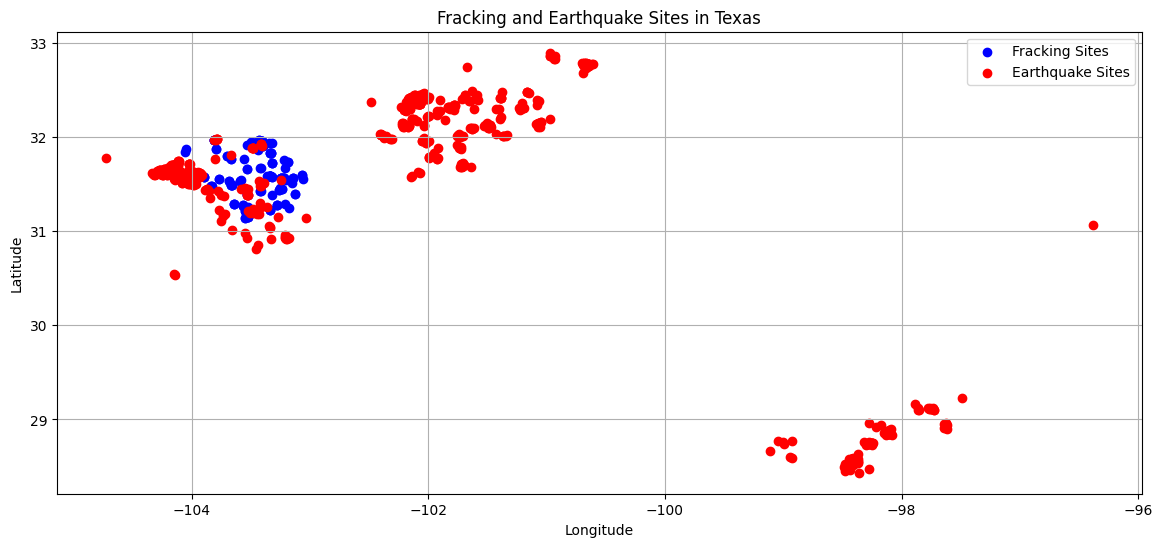

In [10]:
# Extract the latitude and longitude values for each fracking site,
# using the transformed WGS84 coordinates.
frac_lats = [site.Latitude_WGS84 for site in fracking_data_list]
frac_lons = [site.Longitude_WGS84 for site in fracking_data_list]

# Extract the latitude and longitude values for each earthquake event.
eq_lats = [eq.Lat for eq in earthquake_data]
eq_lons = [eq.Long for eq in earthquake_data]

# Create a figure with a specified size.
plt.figure(figsize=(14, 6))

# Plot fracking sites as blue markers on the 2D map.
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')

# Plot earthquake sites as red markers.
plt.scatter(eq_lons, eq_lats, color='red', label='Earthquake Sites')

# Label the axes.
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a title to the plot.
plt.title('Fracking and Earthquake Sites in Texas')

# Enable a grid for better visualization of the coordinate system.
plt.grid(True)

# Add a legend to distinguish between fracking sites and earthquake sites.
plt.legend()

# Display the final plot.
plt.show()


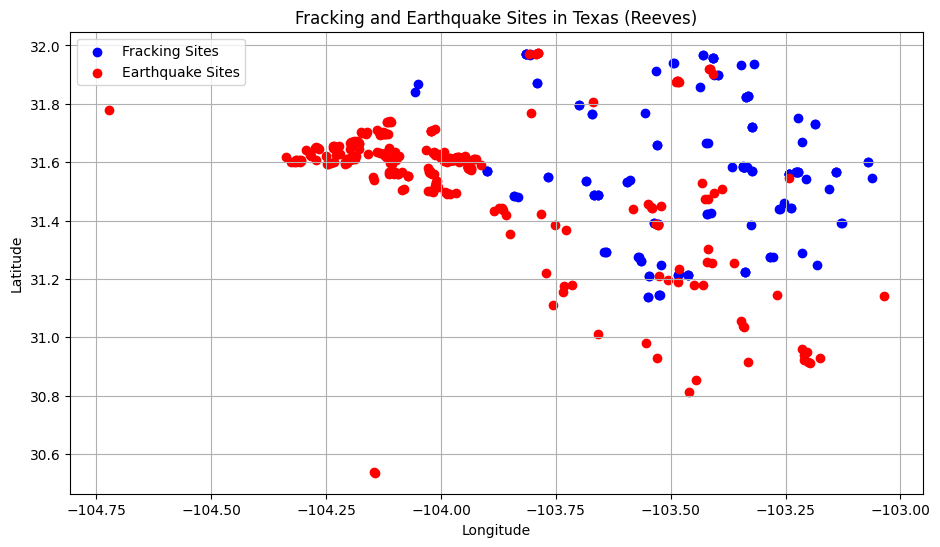

In [11]:
# Filter earthquake data to include only those with a longitude less than -102.5.
filtered_earthquake_data = [eq for eq in earthquake_data if eq.Long < -102.5]

# Extract WGS84 coordinates for all fracking sites.
frac_lats = [site.Latitude_WGS84 for site in fracking_data_list]
frac_lons = [site.Longitude_WGS84 for site in fracking_data_list]

# Extract coordinates for the filtered earthquake events.
eq_lats = [eq.Lat for eq in filtered_earthquake_data]
eq_lons = [eq.Long for eq in filtered_earthquake_data]

plt.figure(figsize=(11, 6))
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')
plt.scatter(eq_lons, eq_lats, color='red', label='Earthquake Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking and Earthquake Sites in Texas (Reeves)')
plt.grid(True)
plt.legend()
plt.show()

In [28]:
frac_site = fracking_data_list[49]
frac_site_surface_coords = (frac_site.Latitude_WGS84, frac_site.Longitude_WGS84, 0)  # Surface coordinates (z=0)
frac_site_depth_coords = (frac_site.Latitude_WGS84, frac_site.Longitude_WGS84, frac_site.TVD_Km)

graph = nx.Graph()
graph.add_node("Fracking Site (Surface)", pos=frac_site_surface_coords)
graph.add_node("Fracking Depth", pos=frac_site_depth_coords)
graph.add_edge("Fracking Site (Surface)", "Fracking Depth")

for eq in earthquake_data:
  eq_coords = (eq.Lat, eq.Long, 0)  # Earthquake surface coordinates (z=0)
  graph.add_node(f"Earthquake Site {eq.Place} , Coordinates ({eq.Lat:.2f}, {eq.Long:.2f})", pos=eq_coords)

# Get node positions and invert z-coordinates so that the surface appears at the top.
pos = nx.get_node_attributes(graph, 'pos')
for node, coords in pos.items():
  pos[node] = (coords[0], coords[1], -coords[2])

# Create a custom text list to show fracking site coordinates on hover.
node_text = []
for node in graph.nodes():
    if "Fracking Site" in node:
        # Retrieve coordinates (x: Longitude, y: Latitude, z: inverted depth; to get actual depth, invert z back).
        x, y, z = pos[node]
        node_text.append(f"{node}, Coordinates: ({y:.2f}, {x:.2f})")
    else:
        node_text.append(node)

# Get earthquake magnitudes and create a color scale.
eq_magnitudes = [eq.Mag for eq in earthquake_data if f"Earthquake Site {eq.Place}" in graph.nodes()]
color_scale = plt.cm.get_cmap('viridis', len(eq_magnitudes))

# Create Plotly trace for nodes with hover text only.
node_trace = go.Scatter3d(
  x=[pos[node][0] for node in graph.nodes()],
  y=[pos[node][1] for node in graph.nodes()],
  z=[pos[node][2] for node in graph.nodes()],
  mode='markers',
  marker=dict(
      size=5,
      color=[color_scale(i) if 'Earthquake Site' in node else 'blue' for i, node in enumerate(graph.nodes())],
      colorscale='Viridis',
      colorbar=dict(title='Magnitude')
  ),
  text=node_text,  # Use the custom text list for hover info.
  hoverinfo='text'
)

# Create Plotly trace for edges.
edge_x = []
edge_y = []
edge_z = []
for edge in graph.edges():
  x0, y0, z0 = pos[edge[0]]
  x1, y1, z1 = pos[edge[1]]
  edge_x += tuple([x0, x1, None])
  edge_y += tuple([y0, y1, None])
  edge_z += tuple([z0, z1, None])

edge_trace = go.Scatter3d(
  x=edge_x, y=edge_y, z=edge_z,
  mode='lines',
  line=dict(color='gray', width=2),
  hoverinfo='none'
)

# Create and show the Plotly figure.
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Fracking Site(Depth) and Nearby Earthquake (3D Movable)",
                    scene=dict(
                        xaxis_title="Longitude",
                        yaxis_title="Latitude",
                        zaxis_title="Depth (km)",
                        xaxis=dict(
                            backgroundcolor="rgb(200, 200, 230)",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white"
                        ),
                        yaxis=dict(
                            backgroundcolor="rgb(230, 200, 230)",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white"
                        ),
                        zaxis=dict(
                            backgroundcolor="rgb(230, 230, 200)",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white"
                        )
                    ),
                    showlegend=True,
                )
)
fig.show()


<ipython-input-28-ab5a2f886b87>:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [29]:
radius_threshold_km = 10  # Horizontal radius threshold in km
time_window_days = 10     # Time window days after JobEndDate

results = {}

# Enumerate over fracking sites to use the site index in the key (e.g., "loc[3]")
for i, site in enumerate(fracking_data_list):
    site_results = []
    # Use the site's WGS84 coordinates for horizontal distance calculation
    site_coords = (site.Latitude_WGS84, site.Longitude_WGS84)

    for eq in earthquake_data:
        # Calculate horizontal distance (km) between the site and the earthquake
        horizontal_dist = geodesic(site_coords, (eq.Lat, eq.Long)).kilometers

        if horizontal_dist <= radius_threshold_km:
            # Define time window:
            lower_time_bound = site.JobStartDate - datetime.timedelta(days=1)
            upper_time_bound = site.JobStartDate + datetime.timedelta(days=time_window_days - 1)

            if lower_time_bound <= eq.Time <= upper_time_bound:
                # Compute the vertical (depth) difference
                depth_diff = abs(eq.Depth - site.TVD_Km)

                eq_details = {
                    'earthquake_place': eq.Place,
                    'horizontal_distance_km': horizontal_dist,
                    'depth_difference': depth_diff,
                    'earthquake_depth': eq.Depth,
                    'earthquake_coordinates': (eq.Lat, eq.Long),
                    'frc_site_coordinates': (site.Latitude_WGS84, site.Longitude_WGS84),
                    'frackingWatervolume': site.TotalBaseWaterVolume,
                    'fracking_depth': site.TVD_Km,
                    'earthquake_time': eq.Time
                }
                site_results.append(eq_details)

    # Only store the site if there is at least one matching earthquake, using "loc[i]" as key.
    if site_results:
        results[f"loc[{i}]"] = site_results

# Calculate total number of earthquakes across all sites
total_earthquakes = sum(len(eq_list) for eq_list in results.values())

# Print the complete results dictionary (only sites with matching earthquakes) and the total count.
pprint(results)
print("Total earthquakes:", total_earthquakes)


{'loc[129]': [{'depth_difference': 2.340276,
               'earthquake_coordinates': (31.387, -103.532),
               'earthquake_depth': 0.9729,
               'earthquake_place': '2 km NNE of Lindsay, Texas',
               'earthquake_time': datetime.datetime(2024, 8, 14, 18, 47, 7, 128000),
               'frackingWatervolume': 27991278.0,
               'fracking_depth': 3.313176,
               'frc_site_coordinates': (31.3868, -103.5288),
               'horizontal_distance_km': 0.30517950996851917},
              {'depth_difference': 2.340276,
               'earthquake_coordinates': (31.387, -103.533),
               'earthquake_depth': 0.9729,
               'earthquake_place': '2 km NNE of Lindsay, Texas',
               'earthquake_time': datetime.datetime(2024, 8, 14, 13, 7, 56, 402000),
               'frackingWatervolume': 27991278.0,
               'fracking_depth': 3.313176,
               'frc_site_coordinates': (31.3868, -103.5288),
               'horizontal_dist

In [ ]:
def calculate_isi(event):
    # Extract the injected water volume (V), horizontal distance (D), and vertical depth difference (delta)
    V = event['frackingWatervolume']
    D = event['horizontal_distance_km']
    delta = event['depth_difference']

    # Avoid division by zero: Only calculate ISI if both horizontal distance and depth difference are non-zero.
    if D * delta != 0:
        # Compute the Induced Seismicity Index (ISI) using the formula:

        return math.log10(V) / (D * delta)
    else:
        # If the product of horizontal distance and depth difference is zero,
        # return None to indicate that the ISI cannot be computed.
        return None

# Initialize an empty dictionary to store ISI results for each fracking site.
isi_results = {}

# 'results' is the precomputed dictionary that contains matched earthquake events for each fracking site.
# Each key is in the form "loc[i]" where i is the index of the fracking site.
for site, events in results.items():
    site_isi = []  # List to hold ISI results for each earthquake event at the current site.

    # Loop over every earthquake event associated with the current fracking site.
    for event in events:
        # Calculate the ISI for the current event.
        isi = calculate_isi(event)

        # Append a dictionary with selected details (place, coordinates, and the ISI) for further analysis.
        site_isi.append({
            'earthquake_place': event['earthquake_place'],
            'earthquake_coordinates': event['earthquake_coordinates'],
            'ISI': isi
        })
    # Store the list of ISI results under the site's key.
    isi_results[site] = site_isi

# Pretty-print the ISI results dictionary for review.
pprint(isi_results)

# Initialize variables to track the highest ISI value and the corresponding event and fracking site.
highest_isi = -float('inf')
highest_event = None
highest_site = None

# Iterate through the computed ISI results.
for site, events in isi_results.items():
    for event in events:
        isi = event['ISI']  # Retrieve the ISI value for the current event.
        # Update the highest ISI if the current event's ISI is valid and greater than the current highest.
        if isi is not None and isi > highest_isi:
            highest_isi = isi
            highest_event = event  # Store the event details with the highest ISI.
            highest_site = site    # Store the associated fracking site key.

# Print the highest ISI, the associated fracking site, and the event details.
print("Highest ISI:", highest_isi)
print("From site:", highest_site)
print("Event details:", highest_event)


{'loc[56]': [{'ISI': 0.20013049812053305,
              'earthquake_coordinates': (31.606, -103.976),
              'earthquake_place': '36 km NNW of Toyah, Texas'},
             {'ISI': 0.21106575477784248,
              'earthquake_coordinates': (31.609, -103.978),
              'earthquake_place': '37 km NNW of Toyah, Texas'},
             {'ISI': 0.2714927493240965,
              'earthquake_coordinates': (31.603, -103.997),
              'earthquake_place': '37 km NNW of Toyah, Texas'},
             {'ISI': 0.5143993012104661,
              'earthquake_coordinates': (31.605, -103.937),
              'earthquake_place': '33 km WSW of Mentone, Texas'},
             {'ISI': 0.28215062208680464,
              'earthquake_coordinates': (31.488, -103.884),
              'earthquake_place': '21 km NNW of Toyah, Texas'},
             {'ISI': 0.36355924878969775,
              'earthquake_coordinates': (31.604, -103.936),
              'earthquake_place': '33 km WSW of Mentone, Texas'},
  

In [ ]:
# Use the highest-site data from the previous matching (from the 'results' dictionary)
highest_site_data = results[highest_site]

# Set the fracking site's coordinates and depth.
frc_coord = highest_site_data[0]['frc_site_coordinates']
frc_depth = highest_site_data[0]['fracking_depth']

graph = nx.Graph()

# "Fracking Site(Depth)" is placed at its actual depth (TVD_Km).
graph.add_node("Fracking Site(Depth)", pos=(frc_coord[1], frc_coord[0], frc_depth))

# "Fracking Site(Surface)" is placed at the surface (depth = 0).
graph.add_node("Fracking Site(Surface)", pos=(frc_coord[1], frc_coord[0], 0))

# Connect the depth node to the surface node with an edge representing the vertical difference.
vertical_distance = abs(frc_depth - 0)
graph.add_edge("Fracking Site(Depth)", "Fracking Site(Surface)", weight=vertical_distance)

# Add each earthquake node using its actual coordinates and its actual depth.
for event in highest_site_data:
    node_name = f"{event['earthquake_place']}"
    lat, lon = event['earthquake_coordinates']
    depth = event['earthquake_depth']  # Use the actual earthquake depth.
    graph.add_node(node_name, pos=(lon, lat, depth))
    graph.add_edge("Fracking Site(Depth)", node_name, weight=event['horizontal_distance_km'])

# Retrieve node positions from the graph.
pos = nx.get_node_attributes(graph, 'pos')

# Invert the z-coordinates so that the surface (depth = 0) appears at the top of the 3D plot.
for node, coords in pos.items():
    pos[node] = (coords[0], coords[1], -coords[2])
nx.set_node_attributes(graph, pos, 'pos')

# Separate nodes into two groups for creating distinct Plotly traces.
# Nodes with "Fracking Site" in their name are considered fracking site nodes.
frac_nodes = [node for node in graph.nodes() if "Fracking Site" in node]

# All other nodes are earthquake nodes.
eq_nodes = [node for node in graph.nodes() if "Fracking Site" not in node]

# Create a Plotly trace for fracking site nodes.
frac_trace = go.Scatter3d(
    x=[pos[node][0] for node in frac_nodes],
    y=[pos[node][1] for node in frac_nodes],
    z=[pos[node][2] for node in frac_nodes],
    mode='markers',
    marker=dict(size=10, color='blue'),
    # Updated text to include fracking site information
    text=[f"Fracking Site: {highest_site_data[0]['earthquake_place']}"
          if node == "Fracking Site(Depth)" else "Fracking Site(Surface)" for node in frac_nodes],
    name="Fracking Site",
    # Use hovertemplate to display the text
    hovertemplate='%{text}<extra></extra>'
)

# Create a Plotly trace for earthquake nodes.
eq_trace = go.Scatter3d(
    x=[pos[node][0] for node in eq_nodes],
    y=[pos[node][1] for node in eq_nodes],
    z=[pos[node][2] for node in eq_nodes],
    mode='markers',
    marker=dict(size=8, color='red'),
    text=eq_nodes,
    name="Earthquake Sites",
    hoverinfo='text'
)

# Build an edge trace by accumulating coordinates for each edge.
edge_x, edge_y, edge_z = [], [], []
for edge in graph.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_z += [z0, z1, None]

edge_trace = go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none',
    showlegend=False
)

# Create and display the final Plotly figure.
fig = go.Figure(
    data=[edge_trace, frac_trace, eq_trace],
    layout=go.Layout(
        title="3D Plot: Fracking Site (Depth & Surface) and Associated Earthquakes",
        scene=dict(
            xaxis_title="Longitude",
            yaxis_title="Latitude",
            zaxis_title="Depth (km)",
            xaxis=dict(
                backgroundcolor="rgb(200, 200, 230)",
                gridcolor="white",
                showbackground=True,
                zerolinecolor="white"
            ),
            yaxis=dict(
                backgroundcolor="rgb(230, 200, 230)",
                gridcolor="white",
                showbackground=True,
                zerolinecolor="white"
            ),
            zaxis=dict(
                backgroundcolor="rgb(230, 230, 200)",
                gridcolor="white",
                showbackground=True,
                zerolinecolor="white"
            )
        ),
        legend=dict(x=0.02, y=0.98)
    )
)
fig.show()


In [ ]:
import datetime, json, requests
from pprint import pprint

# Define API parameters and endpoint for USGS earthquake data.
param = {
    "format": "geojson",
    "starttime": "2024-03-10",
    "limit": 20000,
    "endtime": "2024-05-30"
}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"

# Fetch data from the API and parse it into a Python dictionary.
response = requests.get(url, params=param)
data = json.loads(response.text)

# Display the entire dataset for initial inspection.
pprint(data)

# Iterate over each earthquake event, filtering for shallow events in Texas.
for feature in data['features']:
    depth = feature['geometry']['coordinates'][2]  # Extract depth from coordinates.
    if depth < 10 and "Texas" in feature['properties']['place']:
        Latitude = feature['geometry']['coordinates'][1]  # Get latitude.
        Longitude = feature['geometry']['coordinates'][0]  # Get longitude.
        # Convert time from milliseconds since epoch to a datetime object.
        event_time = datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000)
        # Print key earthquake details.
        print(f"Mag: {feature['properties']['mag']}, "
              f"Place: {feature['properties']['place']}, "
              f"Time: {event_time}, "
              f"Lat: {Latitude}, "
              f"Long: {Longitude}")
